## Part 3: Predicting hypertension
### Part a:

In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn import metrics
from sklearn.metrics import roc_curve
from nltk.tokenize import word_tokenize

In [2]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [4]:
class Data:
    def __init__(self, data, target):
        self.data = data
        self.target = target
    
class Dataset:
    def __init__(self, train: Data, test: Data):
        self.train = train
        self.test = test

In [5]:
#pt = pd.DataFrame([[1,0,1],[2,0,1],[3,1,0]], columns=["id","label","train"])
#cts = pd.DataFrame([[1,1,5],[1,1,10],[1,2,6],[2,1,4],[3,1,20],[3,1,30],[3,1,40]], columns=["id","type","hr"])

def prepare_data(patients: pd.DataFrame, charts: pd.DataFrame, itemid: int) -> Dataset:
    df = charts
    df = df[df.itemid == itemid].drop("itemid", axis=1) \
                                .groupby("hadm_id") \
                                .filter(lambda x: len(x) >= 2) \
                                .groupby("hadm_id") \
                                .agg([np.min, np.max, np.mean]) \
                                .reset_index()
    #df.columns = [''.join(col) if col[1] == '' else '_'.join(col) for col in df.columns.values]
    df.columns = [''.join(col) if col[1] == '' else col[1] for col in df.columns.values]
    df = pd.merge(df, patients, on="hadm_id")

    #min_max_scaler = MinMaxScaler()
    #df.iloc[:,1:4] = min_max_scaler.fit_transform(df.iloc[:,1:4].values.astype(float))

    trainset = df[df.train == 1].copy()
    trainset.reset_index(drop=True, inplace=True)
    trainset.drop(["train", "hadm_id"], axis=1, inplace=True)
    target = trainset.pop("hypertension")
    train = Data(trainset, target)

    testset = df[df.train == 0].copy()
    testset.reset_index(drop=True, inplace=True)
    testset.drop(["train", "hadm_id"], axis=1, inplace=True)
    target = testset.pop("hypertension")
    test = Data(testset, target)

    return Dataset(train, test)

In [6]:
patients_dataset = pd.read_csv("~/csc2548_ml4h/hypertension_patients.gz", compression='gzip')
charts_dataset = pd.read_csv("~/csc2548_ml4h/hypertension_charts.gz", compression='gzip')

patients_dataset.drop("subject_id", axis=1, inplace=True)
charts_dataset.drop("subject_id", axis=1, inplace=True)

In [13]:
#patients_dataset.head()
#charts_dataset.head()
#patients_dataset[patients_dataset.hadm_id.duplicated()].head()
# patients_dataset[patients_dataset.subject_id == 6953]
hr_data = prepare_data(patients_dataset, charts_dataset, 220045)
resp_data = prepare_data(patients_dataset, charts_dataset, 220210)
o2_data = prepare_data(patients_dataset, charts_dataset, 220277)
bp_data = prepare_data(patients_dataset, charts_dataset, 220181)

In [35]:
def perform_logistic_regression(dataset: Dataset):
    logisticRegression = LogisticRegression(penalty='l2', solver='liblinear', max_iter=2000)
    logisticRegression.fit(dataset.train.data, dataset.train.target)
    
    prediction = logisticRegression.predict_proba(dataset.test.data)
    fpr, tpr, thresholds = roc_curve(dataset.test.target.values, prediction[:, 1])
    auc = metrics.auc(fpr, tpr)
    
    predictions = logisticRegression.predict(dataset.test.data)
    print(predictions.sum())
    f1 = metrics.f1_score(dataset.test.target.values, predictions)

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC Score = " + str(round(auc, 2)))
    
    print("F1 Score = " + str(round(f1, 4)))

    accuracy = logisticRegression.score(dataset.test.data, dataset.test.target) * 100
    print("Accuracy = " + str(round(accuracy, 2)) + "%")

Feature: Heart rate in bpm:

0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


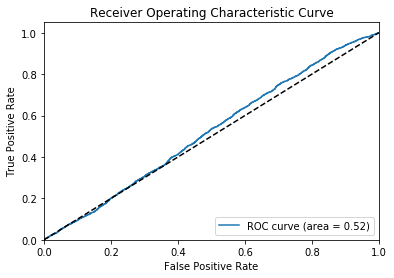

AUC Score = 0.52
F1 Score = 0.0
Accuracy = 56.8%

Feature: Respiratory rate in breaths / minute:

35


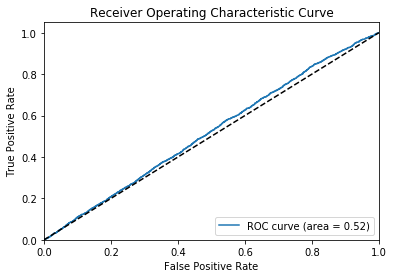

AUC Score = 0.52
F1 Score = 0.0096
Accuracy = 56.7%

Feature: 02 saturation in %:

0


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


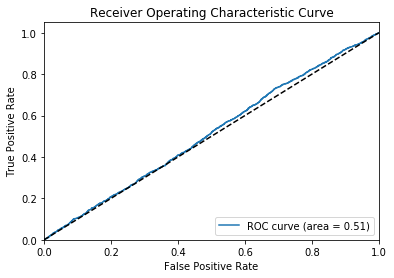

AUC Score = 0.51
F1 Score = 0.0
Accuracy = 56.81%

Feature: Blood pressure in mmHg:

109


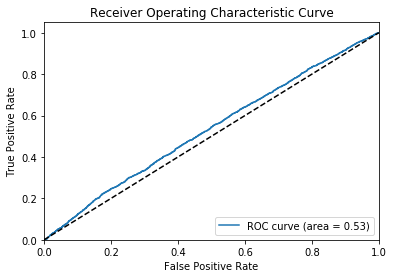

AUC Score = 0.53
F1 Score = 0.0334
Accuracy = 56.68%


In [38]:
print("Feature: Heart rate in bpm:\n")
perform_logistic_regression(hr_data)
print("\nFeature: Respiratory rate in breaths / minute:\n")
perform_logistic_regression(resp_data)
print("\nFeature: 02 saturation in %:\n")
perform_logistic_regression(o2_data)
print("\nFeature: Blood pressure in mmHg:\n")
perform_logistic_regression(bp_data)


### Part b:

In [23]:
from keras.models import Sequential, load_model
from keras.layers import LSTM, Dense
from keras.utils import Sequence

In [24]:
def prepare_lstm_data(patients: pd.DataFrame, charts: pd.DataFrame, itemid: int) -> Dataset:
    df = charts
    df = df[df.itemid == itemid].drop("itemid", axis=1) \
                                .groupby("hadm_id") \
                                .filter(lambda x: len(x) >= 2) \
                                .groupby("hadm_id")

    transformed = [(id,rows.sort_values("charttime").valuenum.values) for (id,rows) in df]
    tdf = pd.DataFrame(transformed, columns=["hadm_id", "sequence"])
    df = pd.merge(tdf, patients, on="hadm_id")
    
    trainset = df[df.train == 1].copy()
    trainset.reset_index(drop=True, inplace=True)
    trainset.drop(["train", "hadm_id"], axis=1, inplace=True)
    target = trainset.pop("hypertension")
    train = Data(trainset.sequence, target)

    testset = df[df.train == 0].copy()
    testset.reset_index(drop=True, inplace=True)
    testset.drop(["train", "hadm_id"], axis=1, inplace=True)
    target = testset.pop("hypertension")
    test = Data(testset.sequence, target)

    return Dataset(train, test)

In [25]:
hr_lstm_data = prepare_lstm_data(patients_dataset, charts_dataset, 220045)
resp_lstm_data = prepare_lstm_data(patients_dataset, charts_dataset, 220210)
o2_lstm_data = prepare_lstm_data(patients_dataset, charts_dataset, 220277)
bp_lstm_data = prepare_lstm_data(patients_dataset, charts_dataset, 220181)

In [26]:
def calc_auc(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    auc = metrics.auc(fpr, tpr)
    return auc

In [37]:
class DataGenerator(Sequence):
    def __init__(self, data: Data):
        self.data = data
    
    def __len__(self):
        return self.data.data.shape[0]
    
    def __getitem__(self, idx):
        x = self.data.data.values[idx].reshape(1,-1,1)
        y = self.data.target.values[idx].reshape(1)
        return x, y

In [31]:
def train_lstm(dataset: Dataset) -> Sequential:
    model = Sequential()
    model.add(LSTM(500, input_shape=(None,1)))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

    model.fit_generator(DataGenerator(dataset.train),
                        epochs=4, verbose=1,
                        validation_data=DataGenerator(dataset.test))
    
    return model

In [ ]:
hr_lstm = train_lstm(hr_lstm_data)
resp_lstm = train_lstm(resp_lstm_data)
o2_lstm = train_lstm(o2_lstm_data)
bp_lstm = train_lstm(bp_lstm_data)

Epoch 1/4
15253/15253 [==============================] - 2629s 172ms/step - loss: 0.6958 - acc: 0.5408 - val_loss: 0.6861 - val_acc: 0.5680
Epoch 2/4
15253/15253 [==============================] - 2800s 184ms/step - loss: 0.6927 - acc: 0.5438 - val_loss: 0.6920 - val_acc: 0.5680
Epoch 3/4
15253/15253 [==============================] - 2323s 152ms/step - loss: 0.6922 - acc: 0.5481 - val_loss: 0.6948 - val_acc: 0.4359
Epoch 4/4
15253/15253 [==============================] - 2345s 154ms/step - loss: 0.6932 - acc: 0.5424 - val_loss: 0.6901 - val_acc: 0.5680
Epoch 1/4
15244/15244 [==============================] - 2351s 154ms/step - loss: 0.6906 - acc: 0.5525 - val_loss: 0.6837 - val_acc: 0.5680
Epoch 2/4
15244/15244 [==============================] - 2420s 159ms/step - loss: 0.6861 - acc: 0.5615 - val_loss: 0.6841 - val_acc: 0.5667
Epoch 3/4
15244/15244 [==============================] - 2426s 159ms/step - loss: 0.6898 - acc: 0.5535 - val_loss: 0.6841 - val_acc: 0.5682
Epoch 4/4
15244/1524

In [ ]:
hr_lstm.save("hr_lstm.h5")
resp_lstm.save("resp_lstm.h5")
o2_lstm.save("o2_lstm.h5")
bp_lstm.save("bp_lstm.h5")

In [38]:
hr_lstm.evaluate_generator(DataGenerator(hr_lstm_data.test), verbose=1)
resp_lstm.evaluate_generator(DataGenerator(resp_lstm_data.test), verbose=1)
o2_lstm.evaluate_generator(DataGenerator(o2_lstm_data.test), verbose=1)
bp_lstm.evaluate_generator(DataGenerator(bp_lstm_data.test), verbose=1)

6658/6658 [==============================] - 124s 19ms/step


[0.6901342132486589, 0.5680384499849804]

6653/6653 [==============================] - 125s 19ms/step


[0.6891853849224518, 0.5699684352923493]

6648/6648 [==============================] - 123s 19ms/step


[0.6905752939881508, 0.5681407942238267]

6545/6545 [==============================] - 71s 11ms/step


[0.686037797805824, 0.5695951107715813]

In [83]:
import warnings
warnings.filterwarnings("ignore")

def evaluate_lstm(model: Sequential, dataset: Dataset):
    predictions = model.predict_generator(DataGenerator(dataset.test), verbose=1)

    fpr, tpr, thresholds = roc_curve(dataset.test.target, predictions.reshape(-1))
    auc = metrics.auc(fpr, tpr)

    f1 = metrics.f1_score(dataset.test.target.values, (predictions.reshape(-1) >= 0.5).astype('int32'))

    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic Curve')
    plt.legend(loc="lower right")
    plt.show()
    print("AUC Score = " + str(round(auc, 4)))
    print("F1 Score = " + str(round(f1, 4)))

Feature: Heart rate in bpm:

6658/6658 [==============================] - 148s 22ms/step


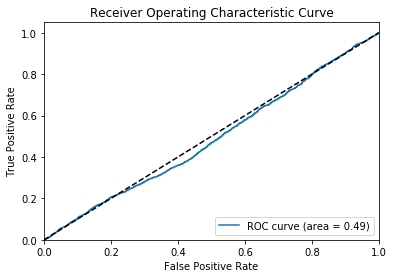

AUC Score = 0.4873
F1 Score = 0.0

Feature: Respiratory rate in breaths / minute:

6653/6653 [==============================] - 161s 24ms/step


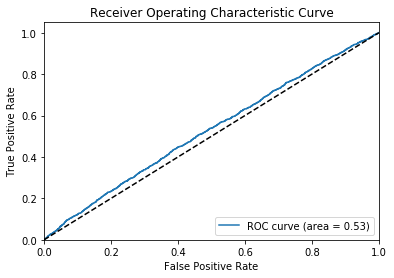

AUC Score = 0.5287
F1 Score = 0.1632

Feature: 02 saturation in %:

6648/6648 [==============================] - 154s 23ms/step


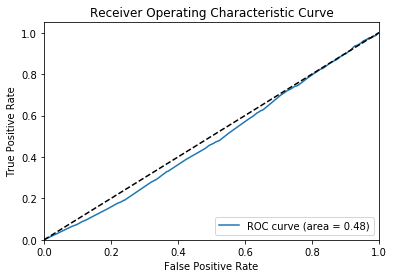

AUC Score = 0.4763
F1 Score = 0.0

Feature: Blood pressure in mmHg:

6545/6545 [==============================] - 79s 12ms/step


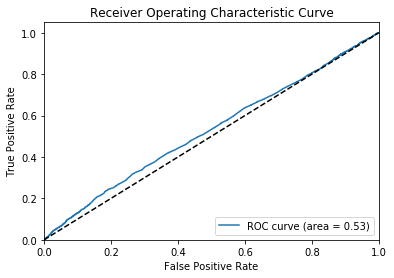

AUC Score = 0.5271
F1 Score = 0.0236


In [84]:
print("Feature: Heart rate in bpm:\n")
evaluate_lstm(hr_lstm, hr_lstm_data)
print("\nFeature: Respiratory rate in breaths / minute:\n")
evaluate_lstm(resp_lstm, resp_lstm_data)
print("\nFeature: 02 saturation in %:\n")
evaluate_lstm(o2_lstm, o2_lstm_data)
print("\nFeature: Blood pressure in mmHg:\n")
evaluate_lstm(bp_lstm, bp_lstm_data)